# Mask R-CNN - Train on Cityscapes Dataset



In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

MODEL_DIR = "/home/gfoil/data/tensorflow_logs/"
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/home/gfoil/.virtualenvs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

In [2]:
class CityscapesConfig(Config):
    """Configuration for training on the Cityscapes dataset.
    Derives from the base Config class and overrides values specific
    to the Cityscapes shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "cityscapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 35  # background + 34 labels

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 1024

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor size in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 64

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 2000

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 15
    
config = CityscapesConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  512
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           cityscapes
NUM_CLASSES                    35
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAININ

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class CityscapesDataset(utils.Dataset):
    """Generates the cityscapes dataset.
    """

    def load_city_images(self, subfolder="train/"):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("cityscapes", 1, "ego vehicle")
        self.add_class("cityscapes", 2, "rectification border")
        self.add_class("cityscapes", 3, "out of roi")
        self.add_class("cityscapes", 4, "static")
        self.add_class("cityscapes", 5, "dynamic")
        self.add_class("cityscapes", 6, "ground")
        self.add_class("cityscapes", 7, "road")
        self.add_class("cityscapes", 8, "sidewalk")
        self.add_class("cityscapes", 9, "parking")
        self.add_class("cityscapes", 10, "rail track")
        self.add_class("cityscapes", 11, "building")
        self.add_class("cityscapes", 12, "wall")
        self.add_class("cityscapes", 13, "fence")
        self.add_class("cityscapes", 14, "guard rail")
        self.add_class("cityscapes", 15, "bridge")
        self.add_class("cityscapes", 16, "tunnel")
        self.add_class("cityscapes", 17, "pole")
        self.add_class("cityscapes", 18, "polegroup")
        self.add_class("cityscapes", 19, "traffic light")
        self.add_class("cityscapes", 20, "traffic sign")
        self.add_class("cityscapes", 21, "vegetation")
        self.add_class("cityscapes", 22, "terrain")
        self.add_class("cityscapes", 23, "sky")
        self.add_class("cityscapes", 24, "person")
        self.add_class("cityscapes", 25, "rider")
        self.add_class("cityscapes", 26, "car")
        self.add_class("cityscapes", 27, "truck")
        self.add_class("cityscapes", 28, "bus")
        self.add_class("cityscapes", 29, "caravan")
        self.add_class("cityscapes", 30, "trailer")
        self.add_class("cityscapes", 31, "train")
        self.add_class("cityscapes", 32, "motorcycle")
        self.add_class("cityscapes", 33, "bicycle")
        self.add_class("cityscapes", -1, "license plate")

        
        image_dir = "/home/gfoil/data/Cityscapes_dataset/leftImg8bit/"
        mask_dir = "/home/gfoil/data/Cityscapes_dataset/gtFine/"
        
        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        i = 0
        
        files = [os.path.join(root,name)
                for root, dirs, files in os.walk(image_dir + subfolder)
                for name in sorted(files)
                if name.endswith((".png", ".jpg"))]
        
        masks = [os.path.join(root,name)
                for root, dirs, files in os.walk(mask_dir + subfolder)
                for name in sorted(files)
                if name.endswith(("_labelIds.png"))]
        
        for f in files:          
            self.add_image("cityscapes", image_id=i, path=f,
                           width=1024, height=512, mask_path=masks[i])
            i += 1

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        """
        info = self.image_info[image_id]
        im = cv2.imread(info['path'])
        image = cv2.resize(im, (0,0), fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)
        #print("loading image ", info['path'])
        return image

    def image_reference(self, image_id):
        """Return the data of the image."""
        info = self.image_info[image_id]
        super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Load instance masks for image of the given image ID.
        """
        info = self.image_info[image_id]
        image = cv2.imread(info['mask_path'])
        mask_im = cv2.resize(image, (0,0), 0, fx=0.5, fy=0.5, interpolation = cv2.INTER_NEAREST) 
        #print("loading mask ", info['mask_path'])
        
        # Map class names to class IDs.
        class_ids = np.unique(mask_im)
        #print(class_ids)
        #mask = [np.where(mask_im[:,:,0] == i)[0].shape[0]
        #         for i in class_ids]
        mask = np.zeros((mask_im.shape[0], mask_im.shape[1], len(class_ids)), dtype='bool')
        
        for c in np.arange(len(class_ids)):
            #print(c)
            inds = (mask_im[:,:] == class_ids[c]).all(axis=2) 
            ##mask[:,:,c] = np.equal(mask_im[:,:,0], c*np.ones((mask_im.shape[0], mask_im.shape[1]), dtype='int'))
            #print(np.sum(inds))
            mask[inds,c] = 1
            #indices = np.where(np.all(mask_im == c, axis=-1))
            #inds = zip(indices[0], indices[1], c*np.ones((len(class_ids)), dtype='int'))
            #count = 0
            #for x,y,c in inds:
            #    mask[x,y,c] = 1
            #    count += 1
            #print(count, " for class ", c)
            #print(mask_im[np.where(mask_im == c)].shape)
            #mask[:,:,c] = mask_im[np.where(mask_im == c)[0]]
        #print("total true", np.sum(mask))
        #print("total avlues", mask.shape[0]*mask.shape[1])
        return mask, class_ids.astype(np.int32)
    
           


In [5]:
# Training dataset
dataset_train = CityscapesDataset()
dataset_train.load_city_images("train/")
dataset_train.prepare()


# Validation dataset
dataset_val = CityscapesDataset()
dataset_val.load_city_images("val/")
dataset_val.prepare()

class InferenceConfig(CityscapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
#print(gt_mask.shape, "output mask shape")


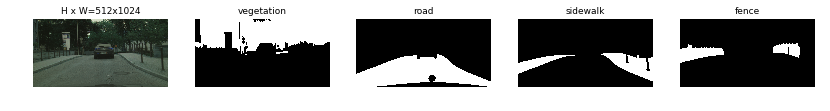

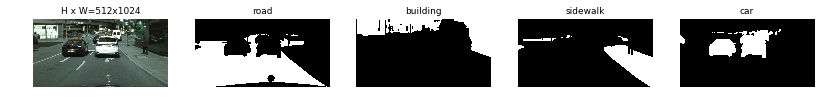

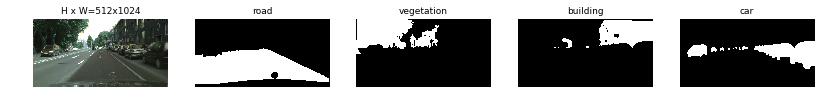

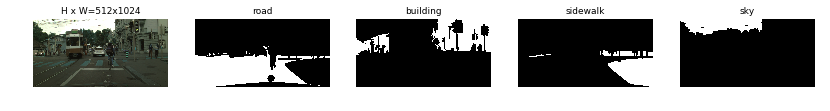

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    #print(class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Ceate Model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [8]:
# Which weights to start with?
#init_with = "coco"  # imagenet, coco, or last
init_with = "last"

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    print(model.find_last()[1])
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

/home/gfoil/data/tensorflow_logs/cityscapes20180123T1954/mask_rcnn_cityscapes_0137.h5


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [9]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=80, 
            layers='heads')


Starting at epoch 138. LR=0.001

Checkpoint Path: /home/gfoil/data/tensorflow_logs/cityscapes20180123T1954/mask_rcnn_cityscapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistrib

/home/gfoil/.virtualenvs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [10]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=160, 
            layers="all")


Starting at epoch 138. LR=0.0001

Checkpoint Path: /home/gfoil/data/tensorflow_logs/cityscapes20180123T1954/mask_rcnn_cityscapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (C

/home/gfoil/.virtualenvs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 139/160
2000/2000 [==============================] - 1499s 750ms/step - loss: 1.1057 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.4245 - mrcnn_class_loss: 0.3308 - mrcnn_bbox_loss: 0.1902 - mrcnn_mask_loss: 0.1499 - val_loss: 5.2807 - val_rpn_class_loss: 0.0422 - val_rpn_bbox_loss: 4.3703 - val_mrcnn_class_loss: 0.4486 - val_mrcnn_bbox_loss: 0.2668 - val_mrcnn_mask_loss: 0.1527
Epoch 140/160
2000/2000 [==============================] - 1443s 721ms/step - loss: 1.1037 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.4204 - mrcnn_class_loss: 0.3317 - mrcnn_bbox_loss: 0.1912 - mrcnn_mask_loss: 0.1504 - val_loss: 6.0282 - val_rpn_class_loss: 0.0518 - val_rpn_bbox_loss: 4.8274 - val_mrcnn_class_loss: 0.6007 - val_mrcnn_bbox_loss: 0.3823 - val_mrcnn_mask_loss: 0.1660
Epoch 141/160
2000/2000 [==============================] - 1445s 722ms/step - loss: 1.1199 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.4344 - mrcnn_class_loss: 0.3334 - mrcnn_bbox_loss: 0.1916 - mrcnn_mask_loss: 0.1501 - val_los

2000/2000 [==============================] - 1446s 723ms/step - loss: 1.0471 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.3794 - mrcnn_class_loss: 0.3236 - mrcnn_bbox_loss: 0.1869 - mrcnn_mask_loss: 0.1481 - val_loss: 7.6295 - val_rpn_class_loss: 0.0721 - val_rpn_bbox_loss: 6.6535 - val_mrcnn_class_loss: 0.4952 - val_mrcnn_bbox_loss: 0.2751 - val_mrcnn_mask_loss: 0.1336


In [11]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_cityscapes.h5")
model.keras_model.save_weights(model_path)

## Detection

In [12]:
class InferenceConfig(CityscapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/gfoil/data/tensorflow_logs/cityscapes20180123T1954/mask_rcnn_cityscapes_0160.h5


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
image_meta               shape: (43,)                 min:    0.00000  max: 1024.00000
gt_class_id              shape: (19,)                 min:    0.00000  max:   33.00000
gt_bbox                  shape: (19, 4)               min:    0.00000  max: 1024.00000
gt_mask                  shape: (1024, 1024, 19)      min:    0.00000  max:    1.00000


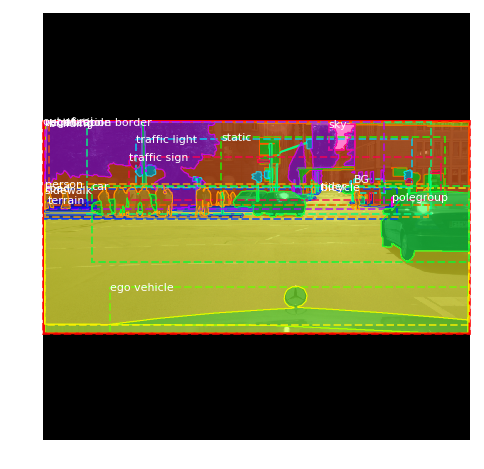

In [18]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

m = visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 43)               min:    0.00000  max: 1024.00000


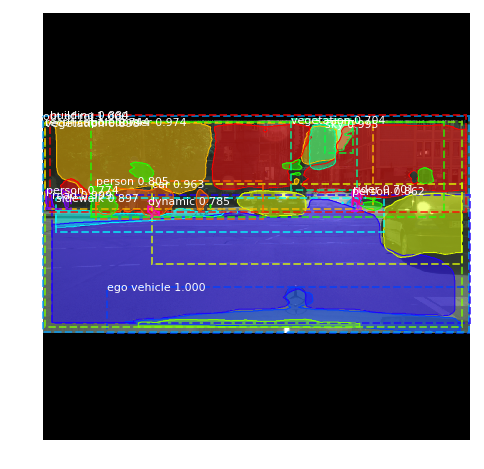

In [19]:
results = model.detect([original_image], verbose=1)
r = results[0]
m = visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [15]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.4072839626861743
